In [5]:
from numpy import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 2.a Load in the joke ratings data and the joke text data into appropriate data structures. Use the "recommend" function to provide top 5 joke recommendations for at least 2 users. Use both standard item-based collaborative filtering (based on the rating prediction function "standEst") and the SVD-based version of the item-based CF (using "svdEst" as the prediction engine) to generate these recommendations for the two users and note the differences. You should show the text of the recommended jokes as well as the predicted ratings for each.

In [6]:
jokes = pd.read_csv('data/jokes/jokes.csv',na_values=['?'],delimiter=",",header=None)
mod_data = pd.read_csv('data/jokes/modified_jester_data.csv',delimiter=",",header=None)

In [7]:
jokes.iloc[:,1][0]

'A man visits the doctor. The doctor says "I have bad news for you.You have cancer and Alzheimer\'s disease". The man replies "Well thank God I don\'t have cancer!"'

In [8]:
mod_data

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,3.18,19.79,1.34,2.84,3.48,2.50,1.15,15.17,2.02,6.24,...,13.82,0.00,0.00,0.00,0.00,0.00,5.37,0.00,0.00,0.00
1,15.08,10.71,17.36,15.37,8.62,1.34,10.27,5.66,19.88,20.22,...,13.82,6.05,10.71,18.86,10.81,8.86,14.06,11.34,6.68,12.07
2,0.00,0.00,0.00,0.00,20.03,20.27,20.03,20.27,0.00,0.00,...,0.00,0.00,0.00,20.08,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,19.35,0.00,0.00,12.80,19.16,8.18,17.21,0.00,12.84,...,0.00,0.00,0.00,11.53,0.00,0.00,0.00,0.00,0.00,0.00
4,19.50,15.61,6.83,5.61,12.36,12.60,18.04,15.61,10.56,16.73,...,16.19,16.58,15.27,16.19,16.73,12.55,14.11,17.55,12.80,12.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12.94,5.47,16.19,5.51,6.92,8.48,14.20,14.83,4.98,13.96,...,6.58,9.93,15.37,7.89,13.72,6.87,13.23,5.47,14.54,13.38
996,15.27,11.39,16.39,5.37,7.41,16.58,12.17,2.84,5.13,4.30,...,0.00,0.00,0.00,0.00,6.58,0.00,0.00,0.00,0.00,0.00
997,16.58,16.63,15.85,7.89,14.40,9.74,14.54,13.14,6.34,11.78,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
998,3.67,4.45,3.67,3.67,9.40,7.65,3.86,4.40,3.67,4.93,...,3.82,6.87,6.87,3.77,3.77,3.77,3.77,3.77,3.77,3.28


In [9]:
def euclidSim(inA,inB):
    return 1.0 / (1.0 + la.norm(inA - inB))

def pearsonSim(inA,inB):
    if len(inA) < 3 : return 1.0
    return 0.5 + 0.5 * corrcoef(inA, inB, rowvar = 0)[0][1]

def cosineSim(inA,inB):
    num = float(inA.T * inB)
    denom = la.norm(inA)*la.norm(inB)
    return 0.5 + 0.5 * (num / denom)



In [10]:

def standEst(dataMat, user, simMeas, item):
    n = shape(dataMat)[1]
    simTotal = 0.0; ratSimTotal = 0.0
    data=mat(dataMat)
    for j in range(n):
        userRating = data[user,j]
        if userRating == 0: continue
        overLap = nonzero(logical_and(data[:,item]>0, data[:,j]>0))[0]
        if len(overLap) == 0:
            similarity = 0
        else:
            similarity = simMeas(data[overLap,item], data[overLap,j])
        #print('the %d and %d similarity is: %f' % (item, j, similarity))
        simTotal += similarity
        ratSimTotal += similarity * userRating
    if simTotal == 0: return 0
    else: return ratSimTotal/simTotal

In [11]:
from numpy import linalg as la

def svdEst(dataMat, user, simMeas, item):
    n = shape(dataMat)[1]
    k = 4 #number of dimension for SVD
    simTotal = 0.0; ratSimTotal = 0.0
    data=mat(dataMat)
    U,Sigma,VT = la.svd(data)
    Sig_k = mat(eye(k)*Sigma[:k]) #arrange Sig_k into a diagonal matrix
    xformedItems = data.T * U[:,:k] * Sig_k.I  #create transformed items
    for j in range(n):
        userRating = data[user,j]
        if userRating == 0 or j==item: continue
        similarity = simMeas(xformedItems[item,:].T, xformedItems[j,:].T)
        #print('the %d and %d similarity is: %f' % (item, j, similarity))
        simTotal += similarity
        ratSimTotal += similarity * userRating
    if simTotal == 0: return 0
    else: return ratSimTotal/simTotal

In [12]:


def recommend(dataMat, user, N=3, simMeas=pearsonSim, estMethod=standEst):
    unratedItems = nonzero(dataMat[user,:].A==0)[1] #find unrated items 
    if len(unratedItems) == 0: return 'you rated everything'
    itemScores = []
    for item in unratedItems:
        estimatedScore = estMethod(dataMat, user, simMeas, item)
        itemScores.append((item, estimatedScore))
    return sorted(itemScores, key=lambda jj: jj[1], reverse=True)[:N]

In [13]:
jokes_arr = np.array(jokes.iloc[:,1])

In [14]:
def topNJokes(u,N,simMeas=pearsonSim,estMethod=standEst):
    recom_jokes = recommend(data_mat,u,N,pearsonSim,estMethod)
    
    if(recom_jokes=='you rated everything'):
        return;
        
    print('*********************Top ',N,' jokes for user#',u,' are : ****************************** \n')
    
    for i in range(len(recom_jokes)):
        print("\t"," JOKE :   (",recom_jokes[i][0],") - ",jokes_arr[recom_jokes[i][0]],'\n\t RATING (Predicted) = ',recom_jokes[i][1],'\n')
        
    print('\n\n')

In [15]:
data_mat = np.mat(mod_data)
N=5

In [16]:

#data_mat[0,:]

for u in range(3):
    topNJokes(u,N)


*********************Top  5  jokes for user# 0  are : ****************************** 

	  JOKE :   ( 71 ) -  On the first day of college the Dean addressed the students pointing out some of the rules:"The female dormitory will be out-of-bounds for all male students and the male dormitory to the female students. Anybody caught breaking this rule will be fined $20 the first time." He continued "Anybody caught breaking this rule the second time will be fined $60. Being caught a third time will cost you a fine of $180. Are there any questions ?"At this point a male student in the crowd inquired:"How much for a season pass ?" 
	 RATING (Predicted) =  7.7688045421022185 

	  JOKE :   ( 88 ) -  A radio conversation of a US naval ship with Canadian authorities ... Americans: Please divert your course 15 degrees to the North to avoid a collision.Canadians: Recommend you divert YOUR course 15 degrees to the South to avoid a collision.Americans: This is the Captain of a US Navy ship.  I say again

In [17]:
data_mat[2,83]

0.0

In [18]:
data_mat = np.mat(mod_data)

for u in range(3):
    topNJokes(u,N,svdEst)


*********************Top  5  jokes for user# 0  are : ****************************** 

	  JOKE :   ( 71 ) -  On the first day of college the Dean addressed the students pointing out some of the rules:"The female dormitory will be out-of-bounds for all male students and the male dormitory to the female students. Anybody caught breaking this rule will be fined $20 the first time." He continued "Anybody caught breaking this rule the second time will be fined $60. Being caught a third time will cost you a fine of $180. Are there any questions ?"At this point a male student in the crowd inquired:"How much for a season pass ?" 
	 RATING (Predicted) =  7.7688045421022185 

	  JOKE :   ( 88 ) -  A radio conversation of a US naval ship with Canadian authorities ... Americans: Please divert your course 15 degrees to the North to avoid a collision.Canadians: Recommend you divert YOUR course 15 degrees to the South to avoid a collision.Americans: This is the Captain of a US Navy ship.  I say again

In [19]:
data_mat[0,78]

0.0

In [20]:
recommendation = recommend(data_mat,0,N,pearsonSim,svdEst)

In [21]:
recommendation

[(71, 7.585854912512737),
 (79, 7.468800594157777),
 (70, 7.441627451919135),
 (88, 7.404666679814133),
 (78, 7.40359554406075)]

### 2.b Complete the definition for the function "test". This function iterates over all users and for each performs evaluation (by calling the provided "cross_validate_user" function), and returns the error information necessary to compute Mean Absolute Error (MAE). Use this function to perform evaluation (with 20% test-ratio for each user) comparing MAE results using the rating prediction function "standEst" with results using the "svdEst" prediction function. [Note: See comments provided in the module for hints on accomplishing these tasks.]

In [22]:

# This function performs evaluation on a single user based on the test_ratio
# For example, with test_ratio = 0.2, a randomly selected 20 percent of rated 
# items by the user are withheld as test data. The remaining part of the user
# profile is used as input for the estimation functions to predict the 
# withheld ratings and compute the error for this user

def cross_validate_user(dataMat, user, test_ratio, estMethod=standEst, simMeas=pearsonSim):
	dataMat = np.array(dataMat)
	number_of_items = np.shape(dataMat)[1]
	rated_items_by_user = np.array([i for i in range(number_of_items) if dataMat[user,i]>0])
	test_size = int(test_ratio * len(rated_items_by_user))
	test_indices = np.random.randint(0, len(rated_items_by_user), test_size)
	withheld_items = rated_items_by_user[test_indices]
	original_user_profile = np.copy(dataMat[user])
	dataMat[user, withheld_items] = 0 # So that the withheld test items is not used in the rating estimation below
	error_u = 0.0
	count_u = len(withheld_items)

	# Compute absolute error for user u over all test items
	for item in withheld_items:
		# Estimate rating on the withheld item
		estimatedScore = estMethod(dataMat, user, simMeas, item)
		error_u = error_u + abs(estimatedScore - original_user_profile[item])	
	
	# Now restore ratings of the withheld items to the user profile
	for item in withheld_items:
		dataMat[user, item] = original_user_profile[item]
		
	# Return sum of absolute errors and the count of test cases for this user
	# Note that these will have to be accumulated for each user to compute MAE
	return error_u, count_u
	


In [23]:
def test(dataMat, test_ratio, estMethod, simMeas=pearsonSim):
    number_of_users = np.shape(data_mat)[0]
    total_error = 0
    total_usecase=0
    for i in range(number_of_users):
        error_u, count_u = cross_validate_user(dataMat,i,test_ratio)
        total_error += error_u;
        total_usecase += count_u
        
    MAE = total_error/total_usecase
    print ('Mean Absoloute Error for ',estMethod,' : ', MAE)
        
    return MAE
    # Write this function to iterate over all users and for each perform evaluation by calling
	# the above cross_validate_user function on each user. MAE will be the ratio of total error 
	# across all test cases to the total number of test cases, across all users
	

In [25]:
%%time
MAE = test(data_mat,0.2,standEst)

Mean Absoloute Error for  <function standEst at 0x000001889EF49E50>  :  3.7235014034358382
Wall time: 2min 58s


In [26]:
print('MAE from test is',MAE)

MAE from test is 3.7235014034358382


##### 2.c Write a new function "print_most_similar_jokes" which takes the joke ratings data, a query joke id, a parameter k for the number similar jokes, and a similarity metric function, and prints the text of the query joke as well as the texts of the top k most similar jokes based on user ratings. [Note: For hints on how to accomplish this task, please see comments at the end of the provided module as well as comments for the provided stub function.]


In [229]:
def knn_search(query_ratings_vector, dataMat, k, metric=cosineSim):
    ratings_df = pd.DataFrame(query_ratings_vector)
    data = pd.DataFrame(dataMat)
#     print(ratings_df.shape)
#     print()
#     print(data.shape)
    
    distances = []
    # comapre each joke from data with the rating vector
    for i in range(dataMat.shape[1]):
        data_rating_vector = dataMat[:,i]
        distances.append(metric(query_ratings_vector, data_rating_vector))
    
    
    distances_arr = np.array(distances);
    #print('distances array shape ',distances_arr.shape)
    distances_arr = distances_arr.argsort()
    
    kNeighbors = zeros((k,dataMat.shape[1]))
    topIndicies = []
    classCount={}
    for i in range(k):
        #voteIlabel = labels[sortedDistIndicies[i]]
        kNeighbors[i,:] = dataMat[distances_arr[i],:]
        topIndicies.append(distances_arr[i])
        
    return kNeighbors, topIndicies


In [230]:
def print_most_similar_jokes(dataMat, jokes, queryJoke, k, metric=pearsonSim):
    # Write this function to find the k most similar jokes (based on user ratings) to a queryJoke
    # The queryJoke is a joke id as given in the 'jokes.csv' file (an corresponding to the a column in dataMat)
    # You must compare ratings for the queryJoke (the column in dataMat corresponding to the joke), to all
    # other joke rating vectors and return the top k. Note that this is the same as performing KNN on the 
    # columns of dataMat. The function must retrieve the text of the joke from 'jokes.csv' file and print both
    # the queryJoke text as well as the text of the returned top-k jokes.
    
    print(' Query joke id',queryJoke, '\n\n query joke = \n   ',jokes[queryJoke])
    ##print(' Ratings\n ',dataMat[:,queryJoke])
    kNeighbors, topIndicies = knn_search(dataMat[:,queryJoke], dataMat, k , metric)
    
    print ("\n\nThe top %d recommended jokes are: "%(k))
    for ind in topIndicies:
        jok = jokes[ind]
        print()
        print ("#",ind," => ",jok)
    return

In [231]:
print_most_similar_jokes(data_mat,jokes_arr,97,10,cosineSim)

 Query joke id 97 

 query joke = 
    Age and Womanhood1. Between the ages of 13 and 18 ... She is like Africa virgin and unexplored. 2. Between the ages of 19 and 35 ... She is like Asia hot and exotic. 3. Between the ages of 36 and 45 ... She is like America fully explored breathtakingly beautiful and free with her resources.4. Between the ages of 46 and 56 ...She is like Europe exhausted but still has points of interest. 5. After 56 she is like Australia ...Everybody knows it's down there but who gives a damn?


The top 10 recommended jokes are: 

# 15  =>  Q. What is orange and sounds like a parrot?  A. A carrot.

# 14  =>  Q:  What did the blind person say when given some matzah?A:  Who the hell wrote this?

# 7  =>  Q. Did you hear about the dyslexic devil worshipper? A. He sold his soul to Santa.

# 12  =>  They asked the Japanese visitor if they have elections in his country.  "Every Morning" he answers.

# 19  =>  What's the difference between a MacIntosh and anEtch-A-Sketch?

#### 2.d Develop your own item-based collaborative filtering recommender that uses a model-based approach (separating the training and the prediction tasks). In the training component, item-item similarities for all pairs of items are computed and stored in an appropriate data structure. Your training function should be able to use different similarity functions (passed as a parameter) including Cosine Similarity or Pearson Correlation. The prediction (or estimation) function should take as parameters a target user, an item, a value of k, and the similarities data structure and return the predicted rating on the target item for the target user. The predicted rating should be based on the weighted average of the target user's ratings on k most similar items to the target item. You should test the prediction accuracy of your estimation function (using a cross-validation similar to part b, above) and provide a plot of cross-validation accuracies across a range of values of k. Using the best value of k, demonstrate the functionality of your recommender by generating recommendations for several anecdotal users (similar to part a, above).

In [174]:
jokes = pd.read_csv('data/jokes/jokes.csv',na_values=['?'],delimiter=",",header=None)
jokes_rating = pd.read_csv('data/jokes/modified_jester_data.csv',delimiter=",",header=None)

In [175]:
print(" jokes ",jokes.shape," \n jokes rating ",jokes_rating.shape)

 jokes  (100, 2)  
 jokes rating  (1000, 100)


In [176]:
jokes_rating.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,3.18,19.79,1.34,2.84,3.48,2.50,1.15,15.17,2.02,6.24,...,13.82,0.00,0.00,0.00,0.00,0.00,5.37,0.00,0.00,0.00
1,15.08,10.71,17.36,15.37,8.62,1.34,10.27,5.66,19.88,20.22,...,13.82,6.05,10.71,18.86,10.81,8.86,14.06,11.34,6.68,12.07
2,0.00,0.00,0.00,0.00,20.03,20.27,20.03,20.27,0.00,0.00,...,0.00,0.00,0.00,20.08,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,19.35,0.00,0.00,12.80,19.16,8.18,17.21,0.00,12.84,...,0.00,0.00,0.00,11.53,0.00,0.00,0.00,0.00,0.00,0.00
4,19.50,15.61,6.83,5.61,12.36,12.60,18.04,15.61,10.56,16.73,...,16.19,16.58,15.27,16.19,16.73,12.55,14.11,17.55,12.80,12.60


In [177]:
jokes_rating.describe(include='all')

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000
mean,8.818540,9.506140,7.65257,5.760030,11.311120,9.398870,10.862890,10.487440,6.623080,10.141500,...,4.668510,4.398860,5.015420,4.463920,4.474250,4.697630,4.840930,4.32064,4.519580,4.34171
std,7.016566,6.813393,7.04054,6.255626,5.019201,7.105225,5.357238,4.804446,6.786949,6.693369,...,6.976533,6.601401,7.115623,6.672744,6.629486,6.762919,6.892321,6.52040,6.380153,6.70066
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.050000,1.150000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
25%,0.000000,2.210000,0.00000,0.000000,7.490000,0.000000,6.427500,6.680000,0.000000,4.010000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
50%,10.170000,10.685000,6.97000,3.280000,11.870000,10.900000,11.290000,10.760000,4.905000,11.490000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
75%,14.842500,15.420000,14.20000,10.950000,14.942500,15.660000,15.042500,14.072500,12.525000,15.722500,...,10.560000,9.450000,12.120000,10.130000,9.702500,10.820000,11.062500,9.26250,10.320000,9.80000
max,20.370000,20.320000,20.32000,20.370000,20.370000,20.370000,20.370000,20.320000,20.370000,20.320000,...,20.270000,20.270000,20.320000,20.320000,20.320000,20.270000,20.370000,20.37000,20.320000,20.27000


### 2.d [Extra Credit]: Develop your own item-based collaborative filtering recommender that uses a model-based approach (separating the training and the prediction tasks). In the training component, item-item similarities for all pairs of items are computed and stored in an appropriate data structure. Your training function should be able to use different similarity functions (passed as a parameter) including Cosine Similarity or Pearson Correlation. The prediction (or estimation) function should take as parameters a target user, an item, a value of k, and the similarities data structure and return the predicted rating on the target item for the target user. The predicted rating should be based on the weighted average of the target user's ratings on k most similar items to the target item. You should test the prediction accuracy of your estimation function (using a cross-validation similar to part b, above) and provide a plot of cross-validation accuracies across a range of values of k. Using the best value of k, demonstrate the functionality of your recommender by generating recommendations for several anecdotal users (similar to part a, above).

In [198]:
vs_matrix = np.mat(jokes_rating)
classes = np.array(jokes.iloc[:,1])

print(" classes ",classes.shape," \n vs_matrix rating ",vs_matrix.shape)

##print(classes)

 classes  (100,)  
 vs_matrix rating  (1000, 100)


In [303]:
def training_model(item_index, dataMat, metric=cosineSim):
    query_ratings_vector = dataMat[:,item_index]
    ratings_df = pd.DataFrame(query_ratings_vector)
    data = pd.DataFrame(dataMat)
#     print(ratings_df.shape)
#     print()
#     print(data.shape)
    
    distances = {}
    distance_arr = []
    similar_item_arr = []
    count = 0
    # comapre each joke from data with the rating vector
    for i in range(dataMat.shape[1]):
        
        ## if current item is same as input item then set the sim as 0
        if (i==item_index):
            distance_arr.append(0)
        else:
            data_rating_vector = dataMat[:,i]
            distance_arr.append(metric(query_ratings_vector, data_rating_vector))
        
        similar_item_arr.append(i)
    distances[item_index] = { 'distance' : distance_arr, 'items' : similar_item_arr}
    
    return distances


In [316]:
def prepare_training_model(dataMat,metric=cosineSim):
    distances = {}
    for i in range(dataMat.shape[1]):
        distances.update(training_model(i,dataMat,metric))
    
    return distances

In [473]:
%%time

vs_matrix = np.mat(jokes_rating)

tpercent = 0.8
tsize = int(tpercent * len(vs_matrix))

training_data_set = vs_matrix[:tsize,:] # 80% training data
test_data_set = vs_matrix[tsize:,:] # 20% training data

## train model for training data
values = prepare_training_model(training_data_set)

Wall time: 305 ms


In [474]:
## values is a map with key as items and values as an array of distance from each of the other items
values.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [486]:
# shpae of distances for item 1 from other items
np.array(values[1]['distance']).shape

(100,)

In [488]:
distance = values[50]['distance']
#sort the distances    
idx = np.argsort(distance)

## get top k similar items
top_k = idx[:2]
top_k

array([50, 74], dtype=int64)

In [489]:
def test(user,item,k,ds):
    user_df = pd.DataFrame(user)
    
    if(k==0):
        return np.array(user_df[item])[0],[]
    
    ## get the distance info for the item
    distance = ds[item]['distance']
    
    #sort the distances    
    idx = np.argsort(distance)
    
    ## get top k similar items
    top_k = idx[:k]
    
    #print("top_k similar items ",top_k)
    
    ratings = np.array(user_df[top_k])
    
    #print("input user's ratings for similar items ",ratings)
    
    dist = sum(ratings)/k
    
#     print(ratings/k)
#     dist = 0
#     for i in range(len(top_k)):
#         #print("\n top_k - i ",i," - ",top_k[i])
#         arr = np.array(values[0]['distance'])
        
#         ## get the average rating of the simialr item(s) 
#         dist += sum(arr)/(arr.shape[0])
        
#     #print(" distance ",dist, " average ",(dist/k) )
    
#     ## return the weighted average rating
#     return dist/k , top_k
    return dist,top_k

In [490]:
np.set_printoptions(precision=2,suppress=True)

item = 50
K = 5
user_number = 100
user = test_data_set[user_number]

#print(np.ravel(user)[item])
pred_rating,top_k = test(user,item,K,values)
print("pred_rating ",pred_rating)

user_updated=np.ravel(user).copy()
user_updated[item] = pred_rating
print('item : ',item,' original rating ',np.ravel(user)[item],' predicted rating ', user_updated[item],)

pred_rating  2.928
item :  50  original rating  0.0  predicted rating  2.928


In [491]:
# This function performs evaluation on a single user based on the test_ratio
# For example, with test_ratio = 0.2, a randomly selected 20 percent of rated 
# items by the user are withheld as test data. The remaining part of the user
# profile is used as input for the estimation functions to predict the 
# withheld ratings and compute the error for this user

def cross_validate_user_modified(dataMat, user, predicted_rating,item):
    dataMat = np.array(dataMat)
    original_user_profile = np.copy(dataMat[user])
    original_user_rating = original_user_profile[item]
    error_u = abs(original_user_rating - predicted_rating)
    # Return sum of absolute errors and the count of test cases for this user
    # Note that these will have to be accumulated for each user to compute MAE
    return error_u

In [492]:
error = cross_validate_user_modified(test_data_set,user_number,pred_rating,item)
print("error ",error)
print(test_data_set.shape[1])

error  2.928
100


In [493]:
%precision %.2f
np.set_printoptions(precision=3)

K = 5
user_number = 100
item = 50
predicted_ratings_arr = []
error_arr = []
mae = math.inf
best_k = 0
VERBOSE = False

if(VERBOSE):
    print("K\t Predicted Rating\t Error")

for k in range(test_data_set.shape[1]):
    user = test_data_set[user_number]
    pred_rating,top_k = test(user,item,k,values)
    error = cross_validate_user_modified(test_data_set,user_number,pred_rating,item)
    
    error_arr.append(error)
    predicted_ratings_arr.append(pred_rating)
    
    if(mae > error and k!=0):
        mae = error
        best_k = k
    
    if(VERBOSE):
        print("\n{} \t{} \t\t {}".format(k,round(pred_rating,2), round(error,2) ))
    
print("Best K = ",best_k," mae = ",mae," predicted rating ",predicted_ratings_arr[best_k])

Best K =  1  mae =  0.0  predicted rating  0.0


Text(0, 0.5, 'Error')

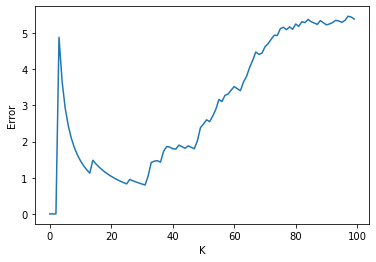

In [494]:
K_values = range(test_data_set.shape[1])
plt.plot(K_values,error_arr,label = "Accuracy Prediction")
plt.xlabel("K")
plt.ylabel("Error")

In [495]:
predicted_ratings_df = pd.DataFrame(predicted_ratings_arr)
#print(predicted_ratings_df.T)

#print(" error ",error_arr)
#sort the ratings
idx = np.argsort(error_arr)

#print("idx ",idx)
## get top k similar items
top_k = idx[:5]

print("top 5 predicted ratings for item '",item,"' for user '",user_number,"' are ")
print(np.ravel(predicted_ratings_df.T[top_k]))

top 5 predicted ratings for item ' 50 ' for user ' 100 ' are 
[0.    0.    0.    0.798 0.825]
